In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import plotly.express as px
import numpy as np
from datetime import timedelta
import requests
from urllib.parse import urlencode

In [2]:
#выставим настройки графика
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

## Проект e-commerce: вариант 1

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

\
\
\
\\


### подгрузим имеющиеся данные

### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [3]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg' 
 
    
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
df_customers = pd.read_csv(download_url) 
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
# df_customers = pd.read_csv('olist_customers_dataset.csv')
# df_customers.head()

In [5]:
df_customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [6]:
#посмотрим на размер датафрейма
df_customers.shape

(99441, 5)

In [7]:
#посмотрим информарцию о датафрейме с пользователями
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
#оценим количество пропущенных значений
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

в данном датафрейме пропущенных значений нет

\
\
\
\\


### olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

### Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

In [9]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' 
 
    
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 

df_orders = pd.read_csv(download_url)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
#посмотрим на размер датафрейма
df_orders.shape

(99441, 8)

In [11]:
#посмотри описание датайрейма
df_orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,cdf9bca93f8e79363ad001dbc570d854,7a40171d9866d44cdeb70537d2727fc6,delivered,2018-08-02 12:06:09,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-14 20:02:44,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [12]:
#посмотрим информарцию о датафрейме с заказами
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


#### мы видим, что колонки с датами имеют формат данных "object". Исправим это

In [13]:
df_orders = df_orders.astype({'order_purchase_timestamp': 'datetime64',
                             'order_approved_at': 'datetime64',
                             'order_delivered_carrier_date': 'datetime64',
                             'order_delivered_customer_date': 'datetime64',
                             'order_estimated_delivery_date': 'datetime64'})
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [14]:
#проверим количество пропущенных значений
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

#### Мы наблюдаем некоторое количество пропущенных значений. В дальшейшем мы примем за "покупку" подтверждение оплаты от покупателя. На данный момент количество пропущенных значений колонке "order_approved_at"(время подтверждения оплаты) 160. Это составляет меньше 0.2% от объема датафрейма. Поэтому для удобства просто удалим эти значения.

In [15]:
df_orders = df_orders[df_orders['order_approved_at'].notna()]
df_orders.shape

(99281, 8)

#### Пропущенные значения в колонках order_delivered_carrier_date(время передачи заказа в логистическую службу) и order_delivered_customer_date(время доставки заказа) могут быть в работе или иметь проблемы их оставим для анализа, потому что клиент оплатил заказ и важно не потерять его в результате проблем с доставкой

\
\
\
\\


### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [16]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' 
 
    
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 

df_order_items = pd.read_csv(download_url)
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
#посмотрим на размер датафрейма
df_order_items.shape

(112650, 7)

In [18]:
#посмотрим информарцию о датафрейме с содержанием заказов
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
# посмотрим описание датафрейма
df_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


#### В датафрейме присутствуют нулевые значения веса. посмотрим количество таких заказов. 

In [20]:
df_order_items.query('freight_value == 0')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
...,...,...,...,...,...,...,...
111094,fc698f330ec7fb74859071cc6cb29772,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-25 02:31:57,53.9,0.0
111497,fd4907109f6bac23f07064af84bec02d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-30 11:31:32,219.0,0.0
111649,fd95e4b85ebbb81853d4a6be3d61432b,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2018-05-04 11:10:31,106.9,0.0
112182,fee19a0dc7358b6962a611cecf6a37b4,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-07 22:06:31,195.0,0.0


In [21]:
df_order_items.query('freight_value == 0').describe()

,order_item_id,price,freight_value
count,383.000000,383.000000,383.0
mean,1.146214,98.601488,0.0
std,0.462782,50.004247,0.0
min,1.000000,53.900000,0.0
25%,1.000000,69.900000,0.0
50%,1.000000,99.900000,0.0
75%,1.000000,106.900000,0.0
max,5.000000,712.900000,0.0


#### Возможно такие заказы имеют слишком маленький вес, поэтому не отображатся в колонке с весом. Количество таких значений не велико, поэтому оставим данные строки для анализа.

In [22]:
#оценим количество пропущенных значений
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

#### в текущем датасете пропущенных значений нет

In [23]:
#приведем столбцы с датами к соответствующему формату
df_order_items = df_order_items.astype({'shipping_limit_date': 'datetime64'})
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [24]:
df_order_items.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


\
\
\
\

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

#### будем считать, что покупка состоялась, когда получили подтверждение оплаты по счету("order_approved_at" не равна NaN) и при этом заказ не был в статусе отменен(canceled) или недоступен(unavailable)

In [25]:
#чтобы ответить на этот вопрос необходимо соединить таблицы с заказами и таблицы с идентификаторами пользователей по колонке
#позаказного id(customer_id)
result = pd.merge(df_orders, df_customers, how='left', on='customer_id')
result.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [26]:
#теперь отфильтруем данные. Уберем из датафрейма строки со статусом заказа "canceled" или "unavailable"
#далее сгруппируем заказ по уникальному id клиента(customer_unique_id)
#посчитаем количество заказов совершенного каждым покупателем
#оставим только тех клиентов, где количество заказов == 1 и посчитаем их сумму
result.query('order_status != "canceled" & order_status != "unavailable"')\
        .groupby('customer_unique_id', as_index=False)\
        .agg({'order_id': 'count'})\
        .rename(columns={'order_id': 'quant_orders'})\
        .query('quant_orders == 1')\
        .quant_orders.sum()

92087

## количество пользователей совершивших покупку один раз составляет -92087

\
\
\
\\


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

#### В качестве "недоставленных заказов" будем рассматривать все заказы, кроме заказов со статусом "delivered"

In [27]:
df_not_delivered = df_orders.query('order_status != "delivered"')
df_not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


In [28]:
df_not_delivered.shape

(2817, 8)

#### Теперь сгруппируем данные по месяцам, предварительно приведя колонку с датой подтверждения платежа "order_approved_at" к виду "год-месяц"

In [29]:
#чтобы сгруппировать данные по месяцам и посчитать среднее количество "недоставленных" заказов, необходимо выделить из столбца 
#"order_approved_at" только дату и месяц. Для этого создадим столбец с датой покупки в формате год-месяц.
df_not_delivered['not_delivered'] = df_not_delivered['order_approved_at'].dt.strftime('%Y-%m')
df_not_delivered.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,not_delivered
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01


In [30]:
#теперь сгруппируем данные по месяцам и посчитаем среднее количество "недоставленных заказов"
df_not_delivered.groupby('not_delivered').agg({'order_id': 'count'}).mean()

order_id    128.045455
dtype: float64

### Среднее количество "не доставленных заказов" в месяц - 128. Выведем детализацию статусов таких заказов

### Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

In [31]:
# сгруппируем наш датафрейм по статусу "order_status"
df_reason = df_not_delivered.groupby('order_status', as_index=False)\
                            .agg({'order_id': 'count'})\
                            .rename(columns={'order_id': 'quantity'})
df_reason

,order_status,quantity
0,approved,2
1,canceled,484
2,invoiced,314
3,processing,301
4,shipped,1107
5,unavailable,609


In [32]:
# для удобства оценки данных создадим еще одну колонку с указанием процентного соотношения каждого статуса
df_reason['ratio,%'] = round(100 * df_reason['quantity']/df_reason['quantity'].sum(), 2)
df_reason

,order_status,quantity,"ratio,%"
0,approved,2,0.07
1,canceled,484,17.18
2,invoiced,314,11.15
3,processing,301,10.69
4,shipped,1107,39.30
5,unavailable,609,21.62


#### На первый взгляд мы видим что большая часть "недоставленных" заказов либо в статусе, отменен, либо в статусе недоступен. Однако Может быть такое что некоторео количество заказов не доехало вовремя. Попробуем оценить какое количество

In [93]:
#для определения таких заказов создадим колонку delta_delivared в которой посчитаем разницу, 
#между планируемой датой доставки и фактической,и возьмем только отрицательные значения
df_delivared = df_orders

In [34]:
df_delivared['delta_delivared'] = df_delivared['order_estimated_delivery_date'] - df_delivared['order_delivered_customer_date']

In [140]:
#выберем из датафрейма только отрицательные значения delta-delivary
df_delivared[df_delivared['delta_delivared'] < pd.to_timedelta(0)].query('order_status != "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,-13 days +01:56:09


#### Заказ, который не был доставлен вовремя- отменен.

### Основные причины не доставки заказа по месяцам:

1. Заказ в сборке
2. Заказ недоступен
3. Заказ отменен
4. Заказ еще не оплачен
5. Заказ в процессе сборки

\
\
\
\\


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [37]:
#соеденим датафрейм заказов с датафреймом состава заказов и запишем в новой датафрейм
df_product_day = pd.merge(df_order_items, df_orders, how='left', on='order_id')
df_product_day

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,7 days 01:03:20
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,8 days 03:28:05
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,12 days 11:37:38
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,8 days 02:00:20


#### Датой покупки будем считать дату подтверждения оплаты "order_approved_at"

In [38]:
#теперь переведем дату покупку в день недели и запишем эти данные в отделньую колонку
df_product_day['day_of_week'] = df_product_day['order_approved_at'].dt.dayofweek
df_product_day.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12,2.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36,2.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44,6.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29,5.0


In [39]:
#сгруппируем данные по продукту(product_id) и дню недели(day_of_week) и сделаем сводную таблицу
df_total_product_day = df_product_day.groupby(['product_id', 'day_of_week'], as_index=False)\
                                    .agg({'order_status': 'count'})\
                                    .sort_values(['product_id', 'day_of_week'])\
                                    .rename(columns={'order_status': 'quant'})\
                                    .groupby(['product_id', 'day_of_week'], as_index=False)\
                                    .agg({'quant': 'max'})\
                                    .sort_values('quant', ascending=False)
df_total_product_day.head()

,product_id,day_of_week,quant
41078,aca2eb7d00ea1a7b8ebd4e68314663af,1.0,119
20148,53b36df67ebb7c41585e8d54d6772e08,1.0,105
41081,aca2eb7d00ea1a7b8ebd4e68314663af,4.0,96
15929,422879e10f46682990de24d770e7f83d,1.0,89
41079,aca2eb7d00ea1a7b8ebd4e68314663af,2.0,89


#### мы получили датафрейм в котором видим какой товар в какой день недели чаще всего покупался. Однако в данном датафрейме присутствуют неинформативные строки в которых товар покупался максимум один раз в данный день недели. Такие строки можно удалить, потому что по данным одной покупки в данный день недели или в другой(который мог отфильтроваться на предыдущем шаге) не выявить закономерностей

In [40]:
df_total_product_day = df_total_product_day.query('quant != 1')
df_total_product_day

,product_id,day_of_week,quant
41078,aca2eb7d00ea1a7b8ebd4e68314663af,1.0,119
20148,53b36df67ebb7c41585e8d54d6772e08,1.0,105
41081,aca2eb7d00ea1a7b8ebd4e68314663af,4.0,96
15929,422879e10f46682990de24d770e7f83d,1.0,89
41079,aca2eb7d00ea1a7b8ebd4e68314663af,2.0,89
...,...,...,...
51641,d7d1cdd61c66570cac78c88a0cae784b,1.0,2
52313,db123b35396aafabb2d5b476557abed5,4.0,2
13753,394b16cd32e9f883365dd7ebac4edbe0,3.0,2
33403,8bef2f3e34f2cc22c908921e6e9eebee,3.0,2


\
\
\
\\


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [41]:
#чтобы посчитать количество покупок в неделю для каждого пользователя. Сначала соеденим таблицы в одну
df_customers_week = pd.merge(pd.merge(df_order_items, df_orders, how='left', on='order_id')
                             , df_customers, how='left', on='customer_id')

In [42]:
#выведим на экран
df_customers_week.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36,eb28e67c4c0b83846050ddfb8a35d051,15775.0,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44,3818d81c6709e39d06b2738a8d3a2474,35661.0,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21,af861d436cfc08b2c2ddefd0ba074622,12952.0,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29,64b576fb70d441e8f1b2d7d446e483c5,13226.0,varzea paulista,SP


In [43]:
#теперь создадим колонку состоящую из месяца и года покупки
df_customers_week['mount_purchase'] = df_customers_week['order_approved_at'].dt.strftime('%Y-%m')

In [44]:
#создадим колонку с указанием недель в каждом месяце
df_customers_week['weeks_in_month'] = round(df_customers_week['order_purchase_timestamp'].dt.days_in_month/7, 2)

In [45]:
#выведим на экран
df_customers_week.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,mount_purchase,weeks_in_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ,2017-09,4.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36,eb28e67c4c0b83846050ddfb8a35d051,15775.0,santa fe do sul,SP,2017-04,4.29
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44,3818d81c6709e39d06b2738a8d3a2474,35661.0,para de minas,MG,2018-01,4.43
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21,af861d436cfc08b2c2ddefd0ba074622,12952.0,atibaia,SP,2018-08,4.43
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29,64b576fb70d441e8f1b2d7d446e483c5,13226.0,varzea paulista,SP,2017-02,4.00


In [46]:
# сгруппируем количество покупок пользователей по месяцам и посчитаем количество покупок в каждом
df_customers_week = df_customers_week.groupby(['customer_unique_id', 'mount_purchase', 'weeks_in_month'], as_index=False)\
                                    .agg({'product_id': 'count'})\
                                    .sort_values('customer_unique_id')\
                                    .rename(columns={'product_id': 'Quant_purchase_in_month'})

In [47]:
df_customers_week.head()

,customer_unique_id,mount_purchase,weeks_in_month,Quant_purchase_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.43,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.43,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.43,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.29,1


In [48]:
#добавим колонку со подсчестом среднего количества покупок в неделю, для каждого пользователя по месяцам.
df_customers_week['mean_purchase_in_week'] = round(df_customers_week.Quant_purchase_in_month / df_customers_week.weeks_in_month, 2)

In [49]:
#пересохраним датафрейм оставив только интересующие нас колонки и отсортируем его по id заказчика и месяцу покупки
df_customers_week = df_customers_week[['customer_unique_id', 'mount_purchase', 'mean_purchase_in_week']]
df_customers_week.sort_values(['customer_unique_id', 'mount_purchase'],ascending=False).head()

,customer_unique_id,mount_purchase,mean_purchase_in_week
97309,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,0.23
97308,ffff5962728ec6157033ef9805bacc48,2018-05,0.23
97307,ffff371b4d645b6ecea244b27531430a,2017-02,0.25
97306,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.23
97305,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.47


\
\
\
\\







## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [50]:
df_orders.sort_values('order_approved_at')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,-37 days +16:12:22
64058,1ff217aa612f6cd7c4255c9bfe931c8b,b3a9bf200375f53cc5c6991919c356fd,delivered,2016-10-04 09:16:33,2016-10-04 09:43:32,2016-10-21 16:33:45,2016-10-24 16:33:45,2016-11-24,30 days 07:26:15
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,16 days 13:01:26
6747,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03 22:31:31,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-14 16:08:00,2016-11-23,39 days 07:52:00
67037,ed8c7b1b3eb256c70ce0c74231e1da88,da0ba2a9935bca5b4610b0e3bca9d3b4,delivered,2016-10-04 09:59:03,2016-10-04 10:25:46,2016-11-11 15:29:14,2016-11-18 08:51:07,2016-11-24,5 days 15:08:53
...,...,...,...,...,...,...,...,...,...
31486,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11,11 days 07:07:29
30077,0b223d92c27432930dfe407c6aea3041,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04,4 days 07:35:05
69678,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03,3 days 07:23:01
88097,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,delivered,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-08-29 16:57:00,2018-08-30 16:23:36,2018-09-05,5 days 07:36:24


#### в таблице присутствуют данные о заказах с сентября 2016го года по октябрь 2018, по условию задания необходимо анализировать заказы с января по декабрь. Делаем вывод, что необходимо проанализировать заказы за 17й год

In [51]:
#для начала уберем данный клиентов которые уже делали заказ в 16м году.
#для этого изначал ьно соеденим таблицу заказов с таблицей данных о клиентах, чтобы знать уникальные идентификаторы клиентов
df_total = pd.merge(df_orders, df_customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [52]:
df_total.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7 days 02:34:47,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,5 days 08:32:15,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,17 days 05:53:31,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,12 days 23:31:18,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9 days 05:42:58,72632f0f9dd73dfee390c9b22eb56dd6


In [53]:
#вычислим дату первой покупки для каждого клиента. Датой покупки считаем дату подтверждения платежа(order_approved_at)
df_first_purchase = df_total.groupby('customer_unique_id', as_index=False)\
                            .agg({'order_approved_at':'min'})\
                            .rename(columns={'order_approved_at': 'date_first_purchase'})

In [54]:
#выведем на экран
df_first_purchase.head()

,customer_unique_id,date_first_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52


In [55]:
#теперь соеденим данные в одну таблицу, чтобы каждый пользователь имел колонку с датой первой покупки
df_total = pd.merge(df_total, df_first_purchase, how='left', on='customer_unique_id')

In [56]:
#отсечем даты первых покупок до 2017-01-01 и после 2018-01-01
df_total = df_total[df_total['date_first_purchase'] > pd.to_datetime('2017-01-01')]
df_total = df_total[df_total['date_first_purchase'] < pd.to_datetime('2018-01-01')]

In [57]:
df_total.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id,date_first_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7 days 02:34:47,7c396fd4830fd04220f754e42b4e5bff,2017-09-04 11:43:25
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,12 days 23:31:18,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,5 days 13:02:05,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 22:10:13
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,NaT,36edbb3fb164b1f16485364b6fb04c73,2017-04-13 13:25:17
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,11 days 11:04:09,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:22:11


In [58]:
#оставим только необходимые для анализа столбцы
df_total_new = df_total[['customer_unique_id', 'order_purchase_timestamp', 'order_approved_at', 'date_first_purchase']]
df_total_new.head()

,customer_unique_id,order_purchase_timestamp,order_approved_at,date_first_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-09-04 11:43:25
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-18 19:45:59
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-09 22:10:13
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04-13 13:25:17,2017-04-13 13:25:17
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-16 13:22:11


In [59]:
#уберем из колонки даты первой покупки время
df_total_new['date_first_purchase'] = df_total_new['date_first_purchase'].dt.normalize()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
df_total_new.head()

,customer_unique_id,order_purchase_timestamp,order_approved_at,date_first_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-09-04
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-18
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-09
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04-13 13:25:17,2017-04-13
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-16


In [61]:
#создадим колонку с датой повторной покупки
df_total_new['date_retention_purchase'] = df_total_new['date_first_purchase'] + pd.DateOffset(months=3)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
#посмотрим результат
df_total_new.head()

,customer_unique_id,order_purchase_timestamp,order_approved_at,date_first_purchase,date_retention_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-09-04,2017-12-04
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-18,2018-02-18
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-09,2017-10-09
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-11 12:22:08,2017-04-13 13:25:17,2017-04-13,2017-07-13
7,932afa1e708222e5821dac9cd5db4cae,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-16,2017-08-16


In [63]:
#приведем колонки с датами к формату месяц-год
df_total_new[['order_purchase_timestamp','order_approved_at','date_first_purchase','date_retention_purchase']] = \
df_total_new[['order_purchase_timestamp','order_approved_at','date_first_purchase','date_retention_purchase']].apply(lambda x: x.dt.strftime('%Y-%m'))

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [64]:
#посмотрим результат
df_total_new.head()

,customer_unique_id,order_purchase_timestamp,order_approved_at,date_first_purchase,date_retention_purchase
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10,2017-09,2017-12
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,2017-11,2018-02
5,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07,2017-07,2017-10
6,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04,2017-04,2017-07
7,932afa1e708222e5821dac9cd5db4cae,2017-05,2017-05,2017-05,2017-08


In [65]:
#теперь сгруппируем данные по датам последующих покупок, дате первой покупке и дате трехмесячной когорты покупки,
#посчитаем количество уникальных клиентов в эти даты
df_retention = df_total_new.groupby(['order_approved_at', 'date_first_purchase', 'date_retention_purchase'],as_index=False)\
                            .agg({'customer_unique_id':'nunique'})\
                            .rename(columns={'customer_unique_id': 'quant_retention_purchase'})
df_retention

,order_approved_at,date_first_purchase,date_retention_purchase,quant_retention_purchase
0,2017-01,2017-01,2017-04,726
1,2017-02,2017-01,2017-04,4
2,2017-02,2017-02,2017-05,1736
3,2017-03,2017-01,2017-04,2
4,2017-03,2017-02,2017-05,4
...,...,...,...,...
166,2018-08,2017-08,2017-11,5
167,2018-08,2017-09,2017-12,3
168,2018-08,2017-10,2018-01,9
169,2018-08,2017-11,2018-02,5


In [66]:
#оставим только те колонки в которых месяца следующих заказов совпадают с третьим месяцем после первой покупки
df_retention = df_retention.query('order_approved_at == date_retention_purchase')

In [67]:
#в таблице не хватает данных по количеству клиентов сделавших заказ в месяц своего прихода на сайт
df_customer_first_purchase = df_total_new.groupby('date_first_purchase', as_index=False)\
                                        .agg({'customer_unique_id': 'nunique'})\
                                        .rename(columns={'customer_unique_id': 'total_first_purchase'})
df_customer_first_purchase

,date_first_purchase,total_first_purchase
0,2017-01,726
1,2017-02,1736
2,2017-03,2643
3,2017-04,2323
4,2017-05,3592
5,2017-06,3148
6,2017-07,3843
7,2017-08,4204
8,2017-09,4148
9,2017-10,4433


In [68]:
#соеденим таблицы df_retention иdf_customer_first_purchase чтобы получить итоговые данные
#запишем получившиеся данные в таблику df_retention
df_retention = pd.merge(df_retention, df_customer_first_purchase, how='left', on='date_first_purchase')
df_retention.head()

,order_approved_at,date_first_purchase,date_retention_purchase,quant_retention_purchase,total_first_purchase
0,2017-04,2017-01,2017-04,1,726
1,2017-05,2017-02,2017-05,3,1736
2,2017-06,2017-03,2017-06,9,2643
3,2017-07,2017-04,2017-07,4,2323
4,2017-08,2017-05,2017-08,14,3592


In [69]:
#создадим новую колонку и в ней посчитаем процент возрата клиентов на третий месяц и отсортируем колонку по убыванию
df_retention['retention'] = 100 * round(df_retention['quant_retention_purchase'] / df_retention['total_first_purchase'], 4)
df_retention.sort_values('retention', ascending=False)

,order_approved_at,date_first_purchase,date_retention_purchase,quant_retention_purchase,total_first_purchase,retention
5,2017-09,2017-06,2017-09,13,3148,0.41
4,2017-08,2017-05,2017-08,14,3592,0.39
2,2017-06,2017-03,2017-06,9,2643,0.34
8,2017-12,2017-09,2017-12,14,4148,0.34
11,2018-03,2017-12,2018-03,18,5638,0.32
7,2017-11,2017-08,2017-11,11,4204,0.26
6,2017-10,2017-07,2017-10,8,3843,0.21
1,2017-05,2017-02,2017-05,3,1736,0.17
3,2017-07,2017-04,2017-07,4,2323,0.17
10,2018-02,2017-11,2018-02,12,7163,0.17


### В результате проведения когортного анализа делаем вывод, что наибольшее retention имеют клиенты совершившие свою первую покупку в июне 2017 года

\
\
\
\\


## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

#### последние данные в таблице заказов датируются 17м октября 2018 года, для RFM анализа возьмем данные за последний год. Датой покупки будем считать дату подтверждения платежа.

In [70]:
#для анализа нам необходимо собрать данную состояющую из таблиц orders, customer и order_items
#из этой таблицы возьмем только небходимые столбцы.
df_rfm = df_order_items.merge(df_orders.merge(df_customers, how='left', on='customer_id'), how='left', on='order_id')
df_rfm.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delta_delivared,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,8 days 00:16:12,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2 days 07:55:36,eb28e67c4c0b83846050ddfb8a35d051,15775.0,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,13 days 10:40:44,3818d81c6709e39d06b2738a8d3a2474,35661.0,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,5 days 10:27:21,af861d436cfc08b2c2ddefd0ba074622,12952.0,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,15 days 07:17:29,64b576fb70d441e8f1b2d7d446e483c5,13226.0,varzea paulista,SP


In [71]:
#отсортируем заказы исключив из выборки заказы со статусом "canceled" и "unavailable"
#так как мы приняли решение считать датой покупки дату подтверждения платежа, то для удобства переименуем эту колонку
#возьмем только нужные колонки
df_rfm = df_rfm.query('order_status != "canceled" and order_status !="unavailable"')\
[['order_id','customer_unique_id','product_id','price', 'order_approved_at']].rename(columns={'order_approved_at': 'date_purchase'})

In [72]:
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26 11:05:13
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04 14:10:13


#### Датой наблюдения будем считать последнюю известную дату в датафрейме orders

In [73]:
#запишем эту дату в отдельную переменную
NOW = df_orders.order_approved_at.max().normalize()
NOW

Timestamp('2018-09-03 00:00:00')

In [74]:
#теперь приведем колонкe типа datatime к дате
df_rfm['date_purchase'] = df_rfm['date_purchase'].dt.normalize()

In [75]:
df_rfm.head()

,order_id,customer_unique_id,product_id,price,date_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04


In [76]:
#отфильтруем данные, удалив покупки совершенные больше года назад
#для этого создадим новую колонку и запишем в нее разницу между датой покупки и датой анализа
df_rfm['delta_date'] = NOW - df_rfm['date_purchase']
df_rfm

,order_id,customer_unique_id,product_id,price,date_purchase,delta_date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13,355 days
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26,495 days
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14,232 days
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08,26 days
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04,576 days
...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,4aa6014eceb682077f9dc4bffebc05b0,299.99,2018-04-25,131 days
112646,fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,32e07fd915822b0765e448c4dd74c828,350.00,2018-07-17,48 days
112647,fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,72a30483855e2eafc67aee5dc2560482,99.90,2017-10-24,314 days
112648,fffe18544ffabc95dfada21779c9644f,eb803377c9315b564bdedad672039306,9c422a519119dcad7575db5af1ba540e,55.99,2017-08-15,384 days


In [77]:
#теперь отфильтруем строки, в которых покупки были совершены более года назад
df_rfm = df_rfm[df_rfm['delta_date'] <= timedelta(days = 365)]
df_rfm

,order_id,customer_unique_id,product_id,price,date_purchase,delta_date
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13,355 days
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14,232 days
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08,26 days
6,00054e8431b9d7675808bcb819fb4a32,635d9ac1680f03288e72ada3a1035803,8d4f2bb7e93e6710a28f34fa83ee7d28,19.90,2017-12-10,267 days
7,000576fe39319847cbb9d288c5617fa6,fda4476abb6307ab3c415b7e6d026526,557d850972a7d6f792fd18ae1400d9b6,810.00,2018-07-05,60 days
...,...,...,...,...,...,...
112644,fffbee3b5462987e66fb49b1c5411df2,ecc3d4eb9b17d2f0865d21f2abecc51c,6f0169f259bb0ff432bfff7d829b9946,119.85,2018-06-19,76 days
112645,fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,4aa6014eceb682077f9dc4bffebc05b0,299.99,2018-04-25,131 days
112646,fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,32e07fd915822b0765e448c4dd74c828,350.00,2018-07-17,48 days
112647,fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,72a30483855e2eafc67aee5dc2560482,99.90,2017-10-24,314 days


#### чтобы оценить дату последней покупки(recency) сгруппируем данные по уникальному id клиента (customer_unique_id), и выберем максимальную дату покупки(date_purchase) чтоб оценить частоту покупок (frequency) и посчитаем для каждого клиента количество заказов(order_id), чтобы посчитать сумму покупок клиента за последний год(monetary), при группировке просуммируем колонку цены(price)

In [111]:
df_rfm_result = df_rfm.groupby('customer_unique_id', as_index=False)\
                        .agg({'delta_date': 'min', 'order_id': 'count', 'price': 'sum'})\
                        .rename(columns={'delta_date': 'recency', 'order_id': 'frequency', 'price': 'monetary'})

In [112]:
df_rfm_result.sort_values('frequency', ascending=False)

,customer_unique_id,recency,frequency,monetary
57292,c8460e4251689ba205045f3ea17884a1,25 days,24,4080.00
56066,c402f431464c72e27330a67f7b94d4fb,191 days,20,2000.00
4322,0f5ac8d5c31de21d2f25e24be15bbffb,280 days,18,1252.35
67213,eae0a83d752b1dd32697e0e7b4221656,131 days,15,1821.73
70908,f7ea4eef770a388bd5b225acfc546604,193 days,14,419.86
...,...,...,...,...
25900,5a989673ac02813d30ffee0254885032,207 days,1,259.90
25901,5a995876f96b9c5b16c690009e92ac6b,39 days,1,169.90
25902,5a99c21d6cfa38e2d98690b4d8fd9584,287 days,1,78.99
25903,5a99dae4c9606abe29dc96573cdf9356,217 days,1,39.99


In [113]:
#для удобства расчетов переведем параметр recency в формат int
df_rfm_result['recency'] = df_rfm_result['recency'].dt.days

In [114]:
#посмотрим описание датафрейма
df_rfm_result.describe()

,recency,frequency,monetary
count,73140.000000,73140.000000,73140.000000
mean,176.345680,1.175226,141.271040
std,98.986564,0.615659,211.934023
min,0.000000,1.000000,0.850000
25%,92.000000,1.000000,47.900000
50%,175.000000,1.000000,89.900000
75%,264.000000,1.000000,152.900000
max,365.000000,24.000000,13440.000000


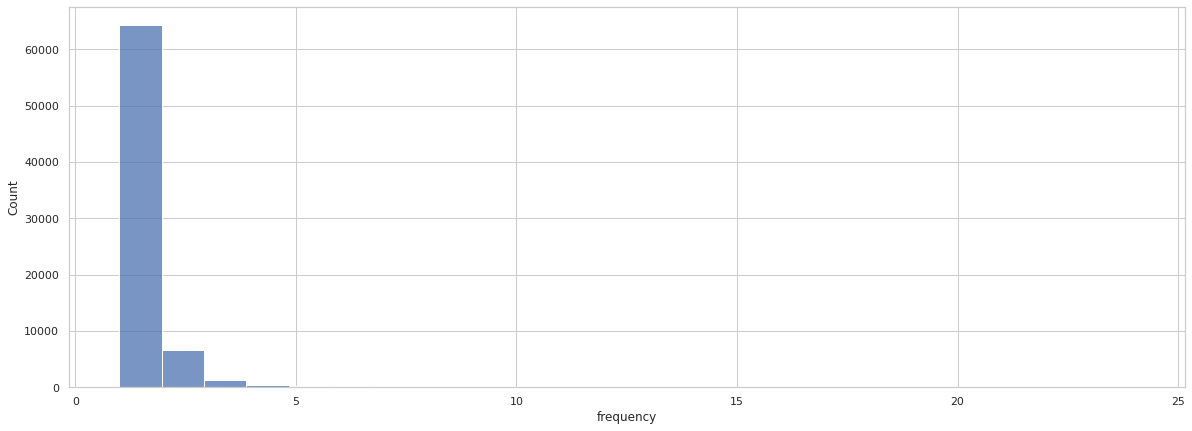

In [115]:
#чтобы понять как лучше сегментировать клиентов, построем гистограммное распределение для каждого из анализирцемых параметров
sns.histplot(df_rfm_result.frequency, bins=24)

#### из построенной гистрограммы видно, что большинство покупок совершались единоразово в течении исследуемого года. попробуем откинуть единоразовые покупки и посмотреть медианное значение, получившихся сегментов.

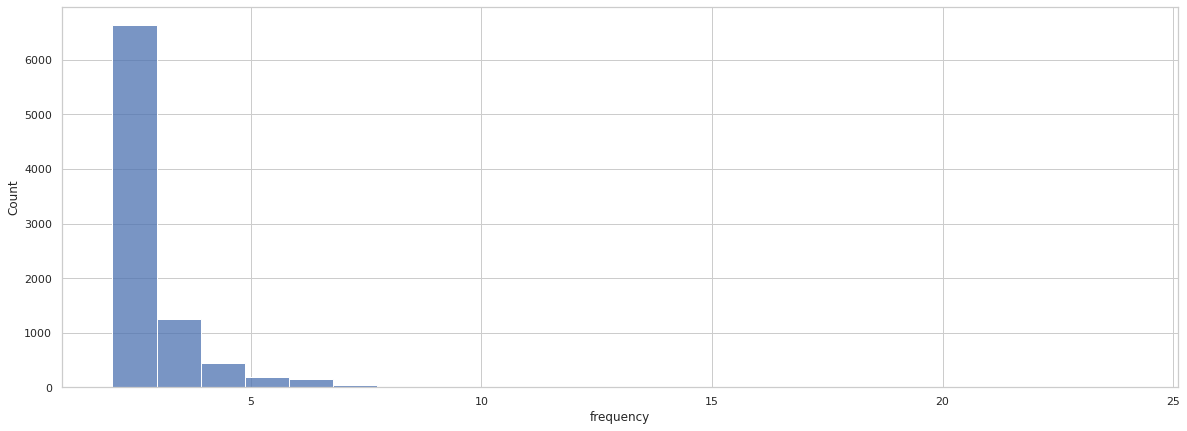

In [116]:
sns.histplot(df_rfm_result.query('frequency > 1').frequency, bins=23)

#### попробуем в гистограмме убрать клиентов с количеством покупок менее 2х и посмотреть распределение

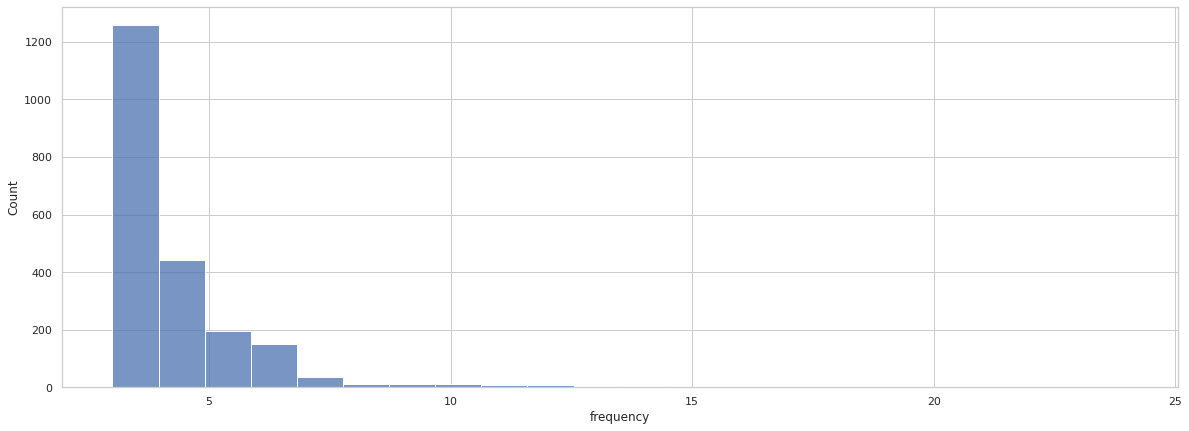

In [117]:
sns.histplot(df_rfm_result.query('frequency > 2').frequency, bins=22)

#### Наблюдаем, что огромное количество покупок совершается единоразово. Далее достаточно много клиентов совершаюи дв покупки в течении год следующий сегмент по количество покупок это клиенты с количеством покупок от 3 до 6, и в последний сегмент выделим всех клиентов чье количество покупок больше 6

Таким образом наиболее правильным распределением для нашей выборки будет следущее:\
1 - клиенты совершившие 1 покупку\
2 - клиенты совершившие 2 покупки\
3 - клиенты совершившие от 3х до 6ти покупок\
4 - клиенты совершившие более 6 покупок

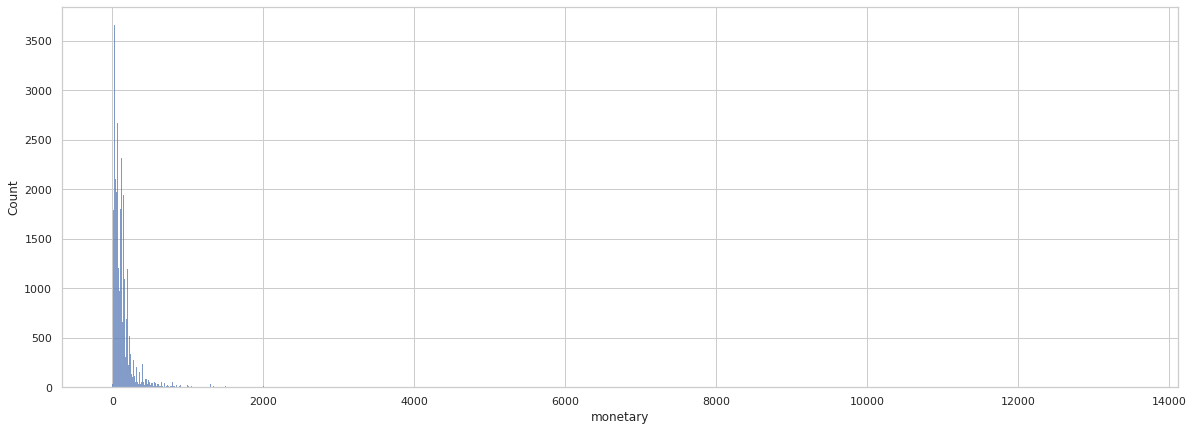

In [118]:
#построим гистограмму для параметра monetary
sns.histplot(df_rfm_result.monetary)

#### На гистограмме видно, что большую часть клиентов суонцентрирована в левой части графика.
Распределение данного параметра построим на основе квантилей. На основе квантилей так же сделаем распределение даты последней покупки.

In [106]:
#создадим функции для сегментации каждого параметра
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def f_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif (x >= 3) and (x <=6):
        return 3
    else:
        return 4
    
def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5   

In [119]:
#зададим словать кватнилей, к интресующим нас характеристикам 
quintiles = df_rfm_result[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 75.0, 0.4: 143.0, 0.6: 207.0, 0.8: 278.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.8}}

In [120]:
#создадим новые колонки соответствующие рангам наших атрибутов
df_rfm_result['R'] = df_rfm_result['recency'].apply(lambda x: r_score(x))
df_rfm_result['F'] = df_rfm_result['frequency'].apply(lambda x: f_score(x))
df_rfm_result['M'] = df_rfm_result['monetary'].apply(lambda x: m_score(x))
df_rfm_result.head()

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4


In [121]:
#создадим третью колонку с сегментацией
df_rfm_result['RFM_Score'] = df_rfm_result['R'].map(str) + df_rfm_result['F'].map(str) + df_rfm_result['M'].map(str)
df_rfm_result.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314


In [122]:
#оценим какое количество сегментов у нас получилось
df_rfm_result.RFM_Score.nunique()

85

#### работать с 85 сегментами неудобно, поэтому на основани RFM_score, разделим клиентов на сегменты, используем показатели частоты F и давности покупки R для назначения основных сегментов. 

Champions -	Купили недавно, покупают часто и тратят больше всего\
Loyal Customers - Покупают на регулярной основе.\
Potential Loyalist - Недавние клиенты со средней частотой.\
Recent Customers - Купили совсем недавно, но не часто.\
Promising - Недавно покупали, но не потратили много.\
Customers Needing Attention -	Выше средней недавности, частоты и денежной стоимости. Хотя может и не так давно купил.\
About To Sleep - Ниже средней давности и частоты. Потеряеv их, если не разогреем повторно повторно.\
At Risk	- Покупал часто, но давно. Нужно вернуть их!\
Can’t Lose - Раньше покупали часто, но давно не возвращали.\
Hibernating	- Последняя покупка была давно и мало заказов. Может быть потерян.

In [136]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2]3': 'at risk',
    r'[1-2]4': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4]4': 'loyal customers',
    r'4[1,2]': 'promising',
    r'5[1,2]': 'new customers',
    r'[4-5]3': 'potential loyalists',
    r'[4-5]4': 'champions'
}

df_rfm_result['Segment'] = df_rfm_result['R'].map(str) + df_rfm_result['F'].map(str)
df_rfm_result['Segment'] = df_rfm_result['Segment'].replace(segt_map, regex=True)
df_rfm_result.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,hibernating
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115,hibernating
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,about to sleep


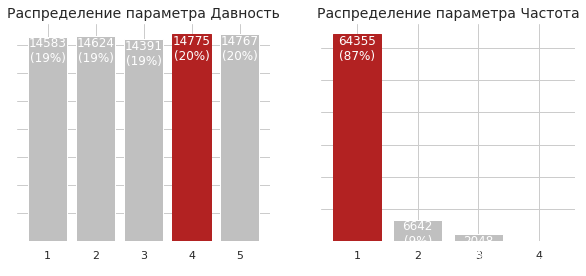

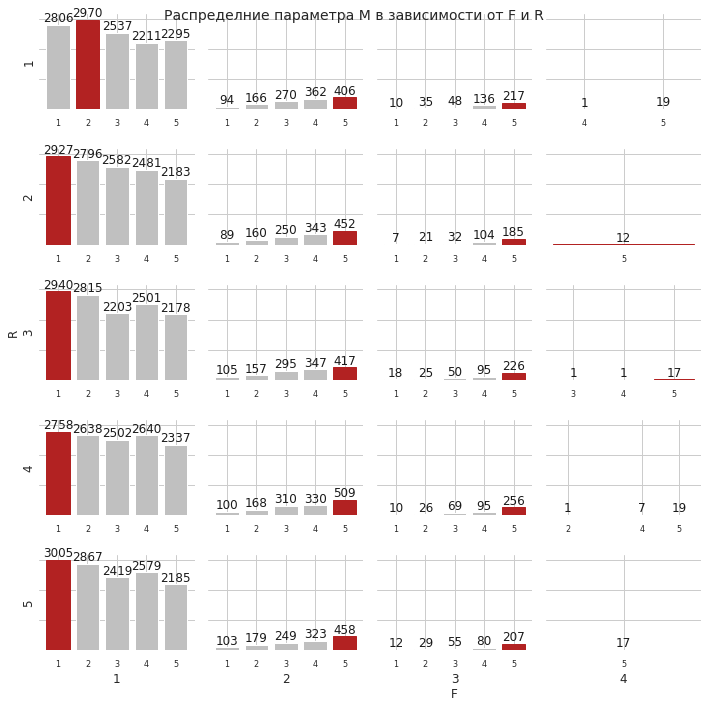

In [137]:
# график распределения клиентов R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Давность', 'F':'Частота'}
    y = df_rfm_result[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение параметра {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# построим график распределения параметр M от RF значений
fig, axes = plt.subplots(nrows=5, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = df_rfm_result[(df_rfm_result['R'] == r) & (df_rfm_result['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределние параметра M в зависимости от F и R',
             fontsize=14)
plt.tight_layout()
plt.show()

#### Из построенного выше графика видно, что параметр давность(R) рапределен равномерно в разрезе года. В то время как частота имеет явный перекос в сторону клиентов совершивших одну покупку.

#### Далее на графиках видно, что для клиентов совершивших покупку один раз распределение доходности является равномерным, в то же время если чем чаще совершается покупка, тем более прибылен такой клиент для компании.

#### Однако количество клиентов совершивштх покупку более 6 раз очень мало, и похоже на выбросов



### Теперь визуализируем выручку компании по сформированным сегментам

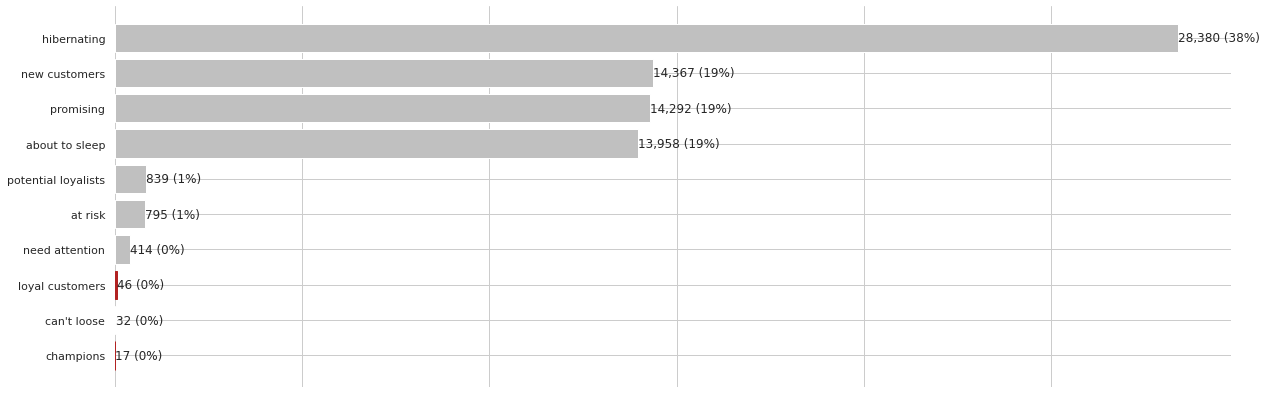

In [138]:
# подсчитаем количество клиентов в каждом сегменте
segments_counts = df_rfm_result['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

#### Из полученной гистограммы видно что наибольшую выручку компании составляют клиенты которые осуществляют 1-2 покупки. В то время как самые выгодные клиенты не составляют даже 1% от общей суммы выручки. Либо в данной компании продается какой то штучный товар, который требует редкой замены, либо у компании серьезные проблемы с лояльностью клиентов, которые в дальнейшем не хотят повторно приобретать продукцию